# Test Your Formatters In Development 

"Formatters" are used to transform the structure of your data to the structure required for deepchecks.\
To help ensure your formatters work as intended, deepchecks has built-in helper functions for formatter validation.\
This guide will demonstrate how to use this helper function to implement formatters for your own data, step by step.


**Structure:**

- [Load data and model](#Load-data-and-model)
- [Load default formatters](#Load-default-formatters)
- [Running the formatters validation](#Running-the-formatters-validation)
- [Understand validation results](#Understand-validation-results)
- [The end result](#The-end-result)

## Load data and model

In the first step we load the DataLoader and our model

In [1]:
from deepchecks.vision.datasets.detection.coco import load_dataset, load_model

data_loader = load_dataset(train=False, batch_size=1000, object_type='DataLoader')
model = load_model()

## Load default formatters

In the second step since this is an object detection task we will load all the object detection appropriate formatters, and initialize them in their default state. We know our DataLoader and model's output are not in the format expected by deepchecks, so when we validate them on our data we will see in the results the formatters are not passing, and then we will implement a correct formatting one by one.

In [2]:
from deepchecks.vision.utils import DetectionLabelFormatter,ImageFormatter, DetectionPredictionFormatter

label_formatter = DetectionLabelFormatter()
image_formatter = ImageFormatter()
pred_formatter = DetectionPredictionFormatter()

## Running the formatters validation

Now we will load our validate function and see the results while running the formatters on our data.\
The function will print for us the validation results. At the end, if all your formatters are valid the output should look in [this](#The-end-result)

In [3]:
from deepchecks.vision.utils.validation import validate_formatters

validate_formatters(data_loader, model, label_formatter, image_formatter, pred_formatter)

Deepchecks will try to validate the formatters given...


## Understand validation results

When looking at the result first thing we see is that it's separated into 2 parts.

First one is about the structure we expect to get. This validation is automatic since it's purely technical and doesn't check content correctness. For example in our validation above we see that the label formatter is passing, meaning the labels are returning in the expected format.\
Second part is about the content, which can't be automatically validated and requires your attention. This part includes looking visually at data outputted by the formatters to validate it is right. In the validation above we see a list of classes that doesn't seem to make sense. T is because although our labels are in the right structure, the content inside is not valid.

We know that the classes in our data are represented by class id which is an int, therefore we understand the labels does not contain the data in the right order.
For the next step we'll fix the label formatter and then validate again:

In [4]:
import torch

def label_formatter_func(batch):
    # Translate labels to deepchecks format.
    # the label_id here is in the last position of the tensor, and the DetectionLabelFormatter expects it
    # at the first position.
    formatted_labels = []
    for tensor in batch[1]:
        tensor = torch.index_select(tensor, 1, torch.LongTensor([4, 0, 1, 2, 3])) if len(tensor) > 0 else tensor
        formatted_labels.append(tensor)
    return formatted_labels

label_formatter = DetectionLabelFormatter(label_formatter_func)

validate_formatters(data_loader, model, label_formatter, image_formatter, pred_formatter)

Deepchecks will try to validate the formatters given...


<hr>
Now we can see in the content section that our classes are indeed as we expect them to be, class ids of type int. Now we can continue and fix the prediction formatter

In [5]:
def yolo_prediction_formatter(batch, model, device):
    # Convert from yolo Detections object to List (per image) of Tensors of the shape [N, 6]"""
    return_list = []
    predictions = model.to(device)(batch[0])
    
    # yolo Detections objects have List[torch.Tensor] xyxy output in .pred
    for single_image_tensor in predictions.pred:
        return_list.append(single_image_tensor)

    return return_list

pred_formatter = DetectionPredictionFormatter(yolo_prediction_formatter)

validate_formatters(data_loader, model, label_formatter, image_formatter, pred_formatter)

Deepchecks will try to validate the formatters given...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling



<hr>
Now our prediction formatter also have valid structure. But in order to really validate it we also need visual assertion and for that we need the image formatter to work.

Deepchecks will try to validate the formatters given...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling




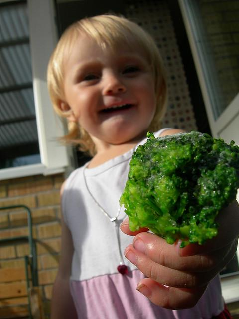
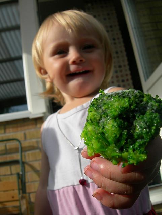

In [6]:
import numpy as np

def pil_image_formatter(batch):
    # Yolo works on PIL and ImageFormatter expects images as numpy arrays
    return [np.array(x) for x in batch[0]]

image_formatter = ImageFormatter(pil_image_formatter)

validate_formatters(data_loader, model, label_formatter, image_formatter, pred_formatter)

<hr>
Now that that image formatter is valid it displays for us visually the label and prediction. When we look at the label we see it is correct, but when we look at the prediction something is broken.

After further reading about `DetectionPredictionFormatter` we see that we have not implemented our format function correctly, so we can fix it and then we will get our final result.

In [7]:
def yolo_prediction_formatter(batch, model, device):
    # Convert from yolo Detections object to List (per image) of Tensors of the shape [N, 6] with each row being 
    # [x, y, w, h, confidence, class] for each bbox in the image."""
    return_list = []
    predictions = model.to(device)(batch[0])

    # yolo Detections objects have List[torch.Tensor] xyxy output in .pred
    for single_image_tensor in predictions.pred:
        pred_modified = torch.clone(single_image_tensor)
        pred_modified[:, 2] = pred_modified[:, 2] - pred_modified[:, 0]  # w = x_right - x_left
        pred_modified[:, 3] = pred_modified[:, 3] - pred_modified[:, 1]  # h = y_bottom - y_top
        return_list.append(pred_modified)

    return return_list


pred_formatter = DetectionPredictionFormatter(yolo_prediction_formatter)

## The end result 

In [ ]:
validate_formatters(data_loader, model, label_formatter, image_formatter, pred_formatter)

Deepchecks will try to validate the formatters given...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling

